## A Tutorial to train and sample from SE(3) Diffusion Models
This notebook visualizes the basic tools for learning and sampling a diffusion model in the Lie Group SE(3). We remark that we decouple the SE(3) between the translation part in R^3 and the Orientation part in SO(3).
 
Setup
    1. Follow the installation procedure in README.md
    2. Download and save grasps, meshes, 


In [16]:
import torch
from torch.autograd import grad
import numpy as np

import theseus as th
from theseus.geometry.so3 import SO3

%matplotlib inline
import matplotlib.pyplot as plt
from se3dif.visualization.grasp_visualization import visualize_grasps
from trimesh import viewer
from IPython import display



## If you want to visualize in 3D with Trimesh, set visualize_2d=False
visualize_2d=True
if visualize_2d:
    import io
    from PIL import Image


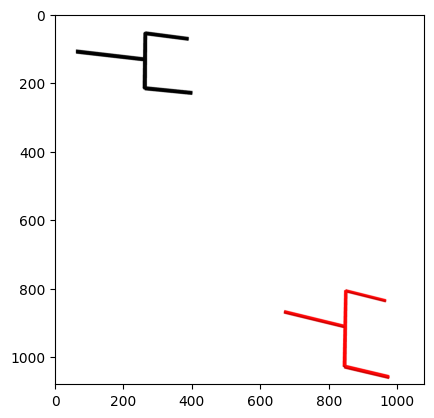

In [17]:
## Sampling from a SE(3) distribution ##

def sample_from_se3_gaussian(x_tar, R_tar, std):
    x_eps = std[:,None]*torch.randn_like(x_tar) # sample translation with std
    theta_eps = std[:,None]*torch.randn_like(x_tar) # sample rotation angle with std
    rot_eps = SO3().exp_map(theta_eps).to_matrix()

    _x = x_tar + x_eps
    _R = torch.einsum('bmn,bnk->bmk',R_tar, rot_eps)
    return _x, _R


B = 1
R_mu = SO3.rand(1).to_matrix().repeat(B,1,1)
x_mu = torch.randn(1, 3).repeat(B,1)
Hmu = torch.eye(4)[None, ...]
Hmu[:, :3, :3] = R_mu[:1, ...]
Hmu[:, :3, -1] = x_mu[:1, :]
std = 0.3*torch.ones(B)


x_samples, R_samples = sample_from_se3_gaussian(x_mu, R_mu, std)
##Ian  Sample H with Hmu, std
H = torch.eye(4)[None,...].repeat(B, 1, 1)
H[:, :3, :3] = R_samples
H[:, :3, -1] = x_samples

H = torch.cat((H, Hmu),dim=0)
colors = torch.zeros_like(H[:,:3,-1])
colors[-1,0]=1

scene = visualize_grasps(Hs=H, colors=colors.numpy(), show=False)


if visualize_2d:
    data = scene.save_image(resolution=(1080,1080))
    image = np.array(Image.open(io.BytesIO(data)))
    plt.imshow(image)
    plt.show()
else:
    display.display(scene.show())


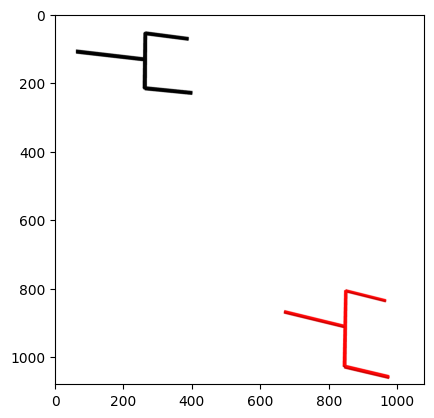

In [18]:
## Evaluate log probability of SE(3) poses in SE(3) Gaussian distribution
##Ian log prbobility of q(H|H_mu,Sigma), be used for sample the log(q) in loss function 
      # q(H|H_mu,Sigma) is a gaussian distribution, this function can get the log probability of q(H)
      # the output of this function is exactly what model want to predict  
def se3_log_probability_normal(x, R, x_tar, R_tar, std):
#x, R: sample; x_tar, R_tar: Hmu
    ## Send to Theseus ##
    _R_tar = SO3()
    _R_tar.update(R_tar)

    if type(R) == torch.Tensor:
        _R = SO3()
        _R.update(R)
        R = _R


    ## Compute distance in R^3 + SO(3) ##
    R_tar_inv = _R_tar.inverse()
    dR = th.compose(R_tar_inv, R)
    dtheta = dR.log_map() #R^3

    dx = (x - x_tar) ##Ian R^3

    dist = torch.cat((dx, dtheta), dim=-1) ##Ian R^6
    return -.5*dist.pow(2).sum(-1)/(std.pow(2))

##Ian log_prob with scalar
log_prob = se3_log_probability_normal(x_samples, R_samples, x_mu, R_mu, std)
prob = torch.exp(log_prob)
colors[:-1, 1] = (prob -prob.min())/(prob.max() + prob.min())

scene = visualize_grasps(Hs=H, colors=colors.numpy(), show=False)

if visualize_2d:
    data = scene.save_image(resolution=(1080,1080))
    image = np.array(Image.open(io.BytesIO(data)))
    plt.imshow(image)
    plt.show()
else:
    display.display(scene.show())


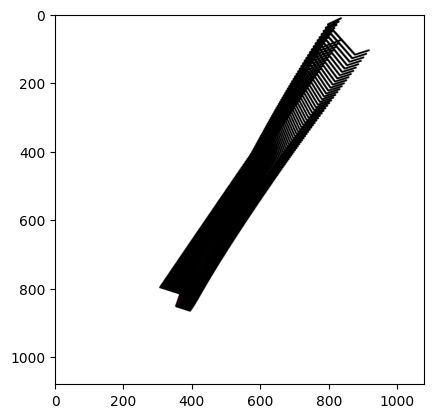

In [20]:
## Move an SE(3) pose given the score of a Gaussian Distribution in SE(3)
#Ian show if we have log se3 score, how to sample

def se3_score_normal(x, R, x_tar, R_tar, std):
#Ian get score function, which is the gradient_x of log q
#                       (log q is log probability of preturb data)
    if type(R) == torch.Tensor:
        _R = SO3()
        _R.update(R)
        R = _R

    ##------------------------------------------ Just for tracking gradient of x_theta
    theta = R.log_map()
    x_theta = torch.cat((x, theta), dim=-1)
    x_theta.requires_grad_(True)
    x = x_theta[..., :3]
    R = SO3.exp_map(x_theta[..., 3:])
    ##------------------------------------------
    d = se3_log_probability_normal(x, R, x_tar, R_tar, std) # here x, R equalt to the argument
    v = grad(d.sum(), x_theta, only_inputs=True)[0] #Dlog(q)/DH, x_teta=H
    return v

def step(x, R, v):
    rot = SO3.exp_map(v[..., 3:]).to_matrix()
    R_1 = torch.einsum('bmn,bnk->bmk', rot, R)

    x_1 = x + v[...,:3]
    return x_1, R_1



R0 = SO3.rand(1).to_matrix()
x0 = torch.randn(1, 3)


T = 1000
dt= 0.01
H_trj = torch.zeros(0,4,4)
for t in range(T):
    H0 = torch.eye(4)
    H0[:3, :3] = R0.detach()[0,...]
    H0[:3, -1] = x0.detach()[0,...]
    H_trj = torch.cat((H_trj, H0[None,...]), dim=0)
    
    v = se3_score_normal(x0, R0, x_tar=x_mu[:1,...], R_tar=R_mu[:1,...], std=torch.ones(1))
    _s = v*dt
    x0, R0 = step(x0, R0, _s)

    
H = torch.cat((H_trj, Hmu),dim=0)
colors = torch.zeros_like(H[:,:3,-1])
colors[-1,0] = 1
scene = visualize_grasps(Hs=H, colors=colors.numpy(), show=False)


if visualize_2d:
    data = scene.save_image(resolution=(1080,1080))
    image = np.array(Image.open(io.BytesIO(data)))
    plt.imshow(image)
    plt.show()
else:
    display.display(scene.show())


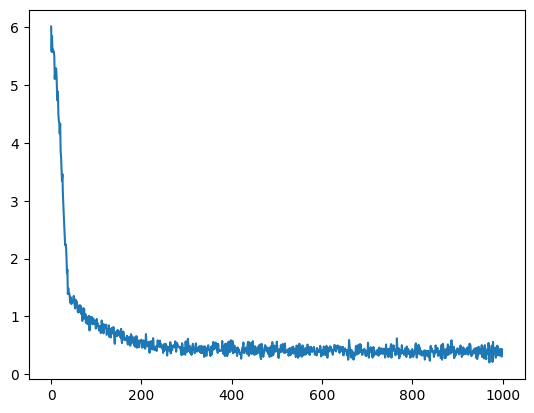

In [26]:
## Training a Simple SE(3) Diffusion Model

def get_sample_from_data(B=100):
# copy data from 2 to B size
    x_data = torch.Tensor([[0.3, 0.3, 0.3],
                           [-0.5, 1.2, -0.7]])
    theta_data = torch.Tensor([[0., 0.0, 0.0],
                               [-0.3, 1.2, -0.4]])
    R_data = SO3().exp_map(theta_data).to_matrix()
    idx = np.random.randint(0, 2, (B,))
    _x = x_data[idx, :]
    _R = R_data[idx, ...]
    return _x, _R


def marginal_prob_std(t, sigma=0.5):
    return torch.sqrt((sigma ** (2 * t) - 1.) / (2. * np.log(sigma)))


## Get Model ##
from se3dif.models.grasp_dif import NaiveSE3DiffusionModel
model = NaiveSE3DiffusionModel()


from torch import optim
optimizer = optim.AdamW(model.parameters(), lr=0.0005)


K = 1000
B = 500
loss_trj = torch.zeros(0)
for k in range(K):
    t = torch.rand(B) + 10e-3
    std = marginal_prob_std(t)
    x, R = get_sample_from_data(B)

    x_eps, R_eps = sample_from_se3_gaussian(x, R, std)
    # gradient of log q, q is probability of gaussian distribution, 
    #              q can be viewd as the probability of noise
    v_tar = se3_score_normal(x_eps, R_eps, x_tar=x, R_tar=R, std=std)

    v_pred = model(x_eps, R_eps, t)

    loss = (std.pow(2))*((v_pred - v_tar).pow(2).sum(-1))
    loss_trj = torch.cat((loss_trj, loss.mean().detach()[None]), dim=0)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
    
plt.plot(loss_trj)
plt.show()

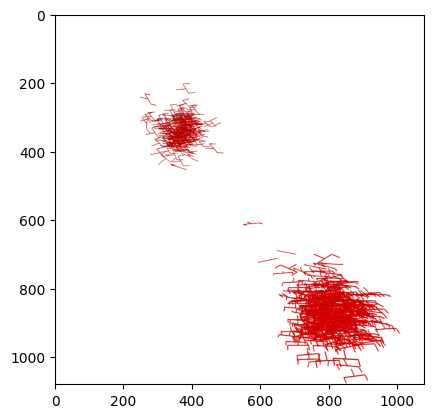

In [6]:
### Given the trained model, run deterministic dynamics over random samples. T=500
# step = 500
R0 = SO3.rand(B).to_matrix()
x0 = torch.randn(B, 3)

T = 500
dt= 0.001
for t in range(T):
    k = (T - t)/T + 10e-3

    v = model(x0, R0, k=k*torch.ones(x0.shape[0]))
    _s = v*dt
    x0, R0 = step(x0, R0, _s)


H_gen = torch.eye(4)[None,...].repeat(B, 1, 1)
H_gen[:, :3, :3] = R0.detach()
H_gen[:, :3, -1] = x0.detach()
colors_gen = torch.zeros_like(H_gen[:,:3,-1])
colors_gen[:,0] = 1

xd, Rd = get_sample_from_data(10)
H_dat = torch.eye(4)[None,...].repeat(xd.shape[0], 1, 1)
H_dat[:, :3, :3] = Rd
H_dat[:, :3, -1] = xd
colors_dat = torch.zeros_like(H_dat[:,:3,-1])
colors_dat[:,1] = 1

H = torch.cat((H_gen, H_dat),dim=0)
c = torch.cat((colors_gen, colors_dat),dim=0)

scene = visualize_grasps(Hs=H, colors=c.numpy(), show=False)


if visualize_2d:
    data = scene.save_image(resolution=(1080,1080))
    image = np.array(Image.open(io.BytesIO(data)))
    plt.imshow(image)
    plt.show()
else:
    display.display(scene.show())

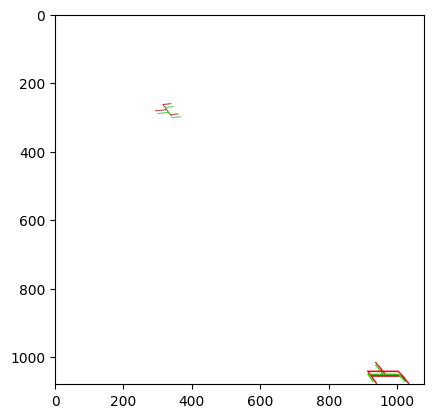

In [7]:
### Given the trained model, run deterministic dynamics over random samples. Use last step only. T = 100
# step = 100
R0 = SO3.rand(B).to_matrix()
x0 = torch.randn(B, 3)

T = 100
dt= 0.001
for t in range(T):
    k = 10e-3

    v = model(x0, R0, k=k*torch.ones(x0.shape[0]))
    _s = v*dt
    x0, R0 = step(x0, R0, _s)


H_gen = torch.eye(4)[None,...].repeat(B, 1, 1)
H_gen[:, :3, :3] = R0.detach()
H_gen[:, :3, -1] = x0.detach()
colors_gen = torch.zeros_like(H_gen[:,:3,-1])
colors_gen[:,0] = 1

xd, Rd = get_sample_from_data(10)
H_dat = torch.eye(4)[None,...].repeat(xd.shape[0], 1, 1)
H_dat[:, :3, :3] = Rd
H_dat[:, :3, -1] = xd
colors_dat = torch.zeros_like(H_dat[:,:3,-1])
colors_dat[:,1] = 1

H = torch.cat((H_gen, H_dat),dim=0)
c = torch.cat((colors_gen, colors_dat),dim=0)

scene = visualize_grasps(Hs=H, colors=c.numpy(), show=False)

if visualize_2d:
    data = scene.save_image(resolution=(1080,1080))
    image = np.array(Image.open(io.BytesIO(data)))
    plt.imshow(image)
    plt.show()
else:
    display.display(scene.show())

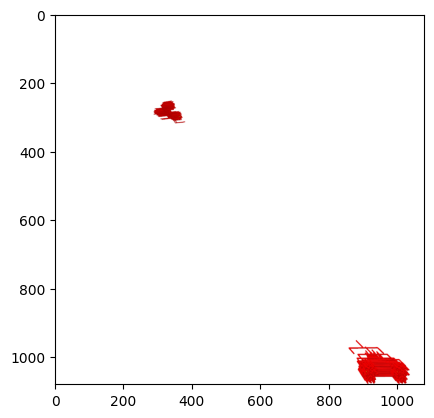

In [8]:
### Given the trained model, run langevin dynamics over random samples.

eps = 10e-2
std_L = marginal_prob_std(t=torch.ones(1))
# random gaussian H
R0 = SO3.rand(B).to_matrix()
x0 = torch.randn(B, 3)

T = 100
dt= 0.001
for t in range(T):
    k = (T - t)/T + 10e-3
    # E_theta
    v = model(x0, R0, k=k*torch.ones(x0.shape[0]))
    
    ## scale ##
    std_k = marginal_prob_std(k*torch.ones(x0.shape[0]))
    alpha = eps*std_k/std_L
    # eq (6)
    _s = v*alpha[:,None].pow(2) + alpha[:,None]*0.1*torch.randn_like(v)
    x0, R0 = step(x0, R0, _s)

## Add a few deterministic steps in last step
T = 30
dt= 0.001
for t in range(T):
    k = 10e-3

    v = model(x0, R0, k=k*torch.ones(x0.shape[0]))
    _s = v*dt
    x0, R0 = step(x0, R0, _s)


H_gen = torch.eye(4)[None,...].repeat(B, 1, 1)
H_gen[:, :3, :3] = R0.detach()
H_gen[:, :3, -1] = x0.detach()
colors_gen = torch.zeros_like(H_gen[:,:3,-1])
colors_gen[:,0] = 1

xd, Rd = get_sample_from_data(10)
H_dat = torch.eye(4)[None,...].repeat(xd.shape[0], 1, 1)
H_dat[:, :3, :3] = Rd
H_dat[:, :3, -1] = xd
colors_dat = torch.zeros_like(H_dat[:,:3,-1])
colors_dat[:,1] = 1

H = torch.cat((H_gen, H_dat),dim=0)
c = torch.cat((colors_gen, colors_dat),dim=0)

scene = visualize_grasps(Hs=H, colors=c.numpy(), show=False)

if visualize_2d:
    data = scene.save_image(resolution=(1080,1080))
    image = np.array(Image.open(io.BytesIO(data)))
    plt.imshow(image)
    plt.show()
else:
    display.display(scene.show())